# Analysis of muon simulations
In this notebook, we aim to analyse the simulations of muon passage with main focus on particles involved, the deposited energy in correlation with time and space.

**[UPDATE]:** the input file has been updated with the new data from CJ (output10000.csv)

**[UPDATE]:** the input file from muon simulations have been renamed in the format `output_Muon_.*.csv`

In [6]:
# import libraries and load data (only meaningful fields)
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 30})

fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output_Muon_10000.csv")
df = pd.read_csv(file_path, index_col=False)
df.head()

df[df.PID==13].groupby("eventnumber").first().reset_index().kineticenergy.describe()

count    8.060000e+02
mean     2.214603e+08
std      3.067048e+08
min      3.116910e+05
25%      4.718052e+07
50%      1.280350e+08
75%      2.810502e+08
max      3.200060e+09
Name: kineticenergy, dtype: float64

## Muon particles: energy deposition, elapsed time and covered space
First, we extract the entries of muon particles to analyse the deposited energy, the elapsed time and the approximate covered space of the whole muon passage. To this aim, we proceed as follow:
1. consider only the entries of muon particles (PID=13) with energy deposition > 0
1. consider only the entries of muon particles, sort them on `time` and compute the elapsed time as `elapsed_time = time[-1] - time[0]`, and the covered space `distance = norm(coord_f - coord_0)`

### Energy deposition
Muons bring very high kinetic energy (*i.e. order of 280 GeV*). During the passage in the LAr volume, they release this energy by energy depositions. Here, we profile the distribution of energy depositions over the passage.

Energy deposition over each event.
count    77852.000000
mean      5267.097273
std       5285.660903
min          0.006208
25%       1506.665000
50%       3642.400000
75%       7270.220000
max      54082.500000
Name: energydeposition, dtype: float64


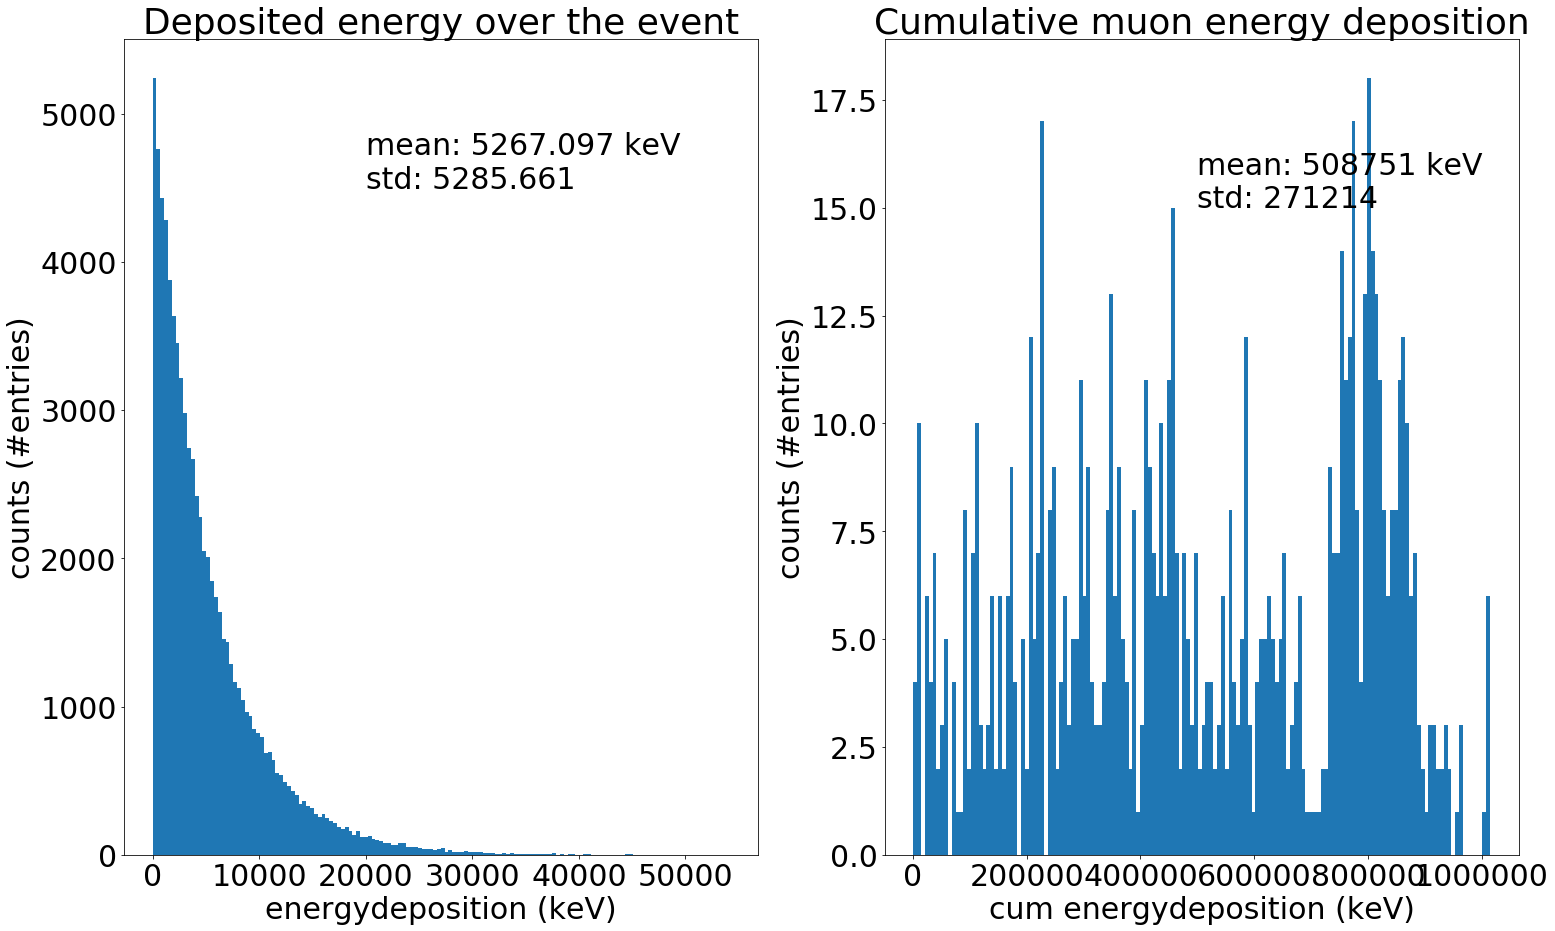

In [4]:
# analyse energy deposition
muons = df[df.PID==13]
muon_energies = muons[muons.energydeposition>0].energydeposition
cum_energy = muons.groupby("eventnumber").energydeposition.sum()
stat = muon_energies.describe()                 # collect statistics
cum_stat = cum_energy.describe()                 # collect statistics
print("Energy deposition over each event.\n{}".format(stat))
mean_e, std_e = stat["mean"], stat["std"]       # mean, std dev

plt.subplot(1, 2, 1)
plt.hist(muon_energies, 150)                    # plot energy distribution wt 500 bins
plt.title("Deposited energy over the event")
plt.xlabel("energydeposition (keV)")
plt.ylabel("counts (#entries)")
plt.text(20000, 4500, "mean: %.3f keV\nstd: %.3f" % (mean_e, std_e))
plt.subplot(1, 2, 2)
plt.hist(cum_energy.values, 150)
plt.title("Cumulative muon energy deposition")
plt.xlabel("cum energydeposition (keV)")
plt.ylabel("counts (#entries)")
plt.text(500000, 15, "mean: %d keV\nstd: %d" % (cum_stat["mean"], cum_stat["std"]))
plt.show()

### Time and space

In [3]:
# analyse elapsed time and space covered (approx distance between final and initial coordinate)
gb_event = muons.sort_values("time").groupby("eventnumber")
time_space = pd.DataFrame()
time_space["time_0"] = gb_event.time.first()
time_space["time_f"] = gb_event.time.last()
time_space["elapsed_time"] = time_space["time_f"] - time_space["time_0"]
time_space["x_0"], time_space["y_0"], time_space["z_0"] = gb_event.x.first(), gb_event.y.first(), gb_event.z.first()
time_space["x_f"], time_space["y_f"], time_space["z_f"] = gb_event.x.last(), gb_event.y.last(), gb_event.z.last()
coord0 = time_space[["x_0", "y_0", "z_0"]].values
coordf = time_space[["x_f", "y_f", "z_f"]].values
time_space["distance"] = (((coord0-coordf)**2).sum(axis=1))**0.5
time_space.head()

,time_0,time_f,elapsed_time,x_0,y_0,z_0,x_f,y_f,z_f,distance
eventnumber,,,,,,,,,,
2,15.9907,24.5466,8.5559,1340.040,446.409,1949.610,1508.120,1236.150,-484.965,2564.975081
12,22.5175,36.0265,13.5090,1730.370,705.926,1200.980,-807.812,538.044,-1950.000,4049.595929
26,19.8843,30.4927,10.6084,-1644.520,1044.410,1128.610,-549.607,1870.940,-1740.600,3180.306957
37,22.5916,33.5736,10.9820,-832.004,-1759.140,812.376,-1614.130,-147.693,-1950.000,3292.294592
60,21.0712,24.6175,3.5463,469.430,1127.410,1932.390,642.002,1841.290,1163.650,1063.187160


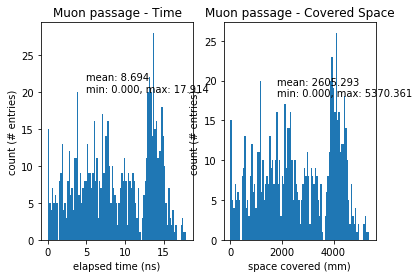

In [4]:
times = time_space.elapsed_time
stat = times.describe()
min_t, max_t, mean_t = stat["min"], stat["max"], stat["mean"]
distances = time_space.distance
stat = distances.describe()
min_d, max_d, mean_d = stat["min"], stat["max"], stat["mean"]
plt.subplot(1, 2, 1)
plt.hist(times, 100)
plt.text(5, 20, "mean: %.3f\nmin: %.3f, max: %.3f" % (mean_t, min_t, max_t))
plt.title("Muon passage - Time")
plt.xlabel("elapsed time (ns)")
plt.ylabel("count (# entries)")
plt.subplot(1, 2, 2)
plt.hist(distances, 100)
plt.text(1800, 18, "mean: %.3f\nmin: %.3f, max: %.3f" % (mean_d, min_d, max_d))
plt.title("Muon passage - Covered Space")
plt.xlabel("space covered (mm)")
plt.ylabel("count (# entries)")
plt.show()


### Observations [old data]:
- muons deposit a lot of **energy** ~500MeV (*cumulative energy deposited in LAr*)
- the energy is deposited over the passage in LAr. Each **deposition** is in order of ~5MeV, with a lot of small depositions (*75% is below 7.5MeV*) and few high depositions (*25% in 10-40MeV*)
- considering the **space** and **time** between the first and the last deposition: each muon covers ~3.8 meters and spends ~13 ns to cross the LAr volume

### Observations [new data]:
- muons still deposit a lot of **energy** ~750MeV (*cumulative energy deposited in LAr*). The difference is because the `old data` use fixed initial energy, whilst the new data use initial muon energy from `MUSUN`.
- the energy is deposited over the passage in LAr. Each **deposition** is still in order of ~5MeV, with a lot of small depositions (*75% is below 7.5MeV*) and few high depositions (*25% in 10-55MeV*)
- considering the **space** and **time** between the first and the last deposition: each muon covers ~2.5m in average (*because non-vertical trajectory*) with a maximum of ~5m (*crossing the LAr diagonally*). The muons spend less than ~18 ns to cross the LAr volume.

## Muon-induced processes
In this second section, we aim to analyse the physical interactions induced by the muon passage in LAr. In particular, we look for the particles that directly interact with the muon and try to figure out the physical process associated and its characterization (w.r.t. energy).

We notice that most of the particle forced by the muon passage are *electrons* (e-), this is because of the *muon ionization*.
Other particles forced are the *photons* (gamma), a few *neutrons* (n), and a few *argon* atoms (Ar38, Ar40). 

The distribution of particles that directly interact with the muon is reported in the following pie charts.

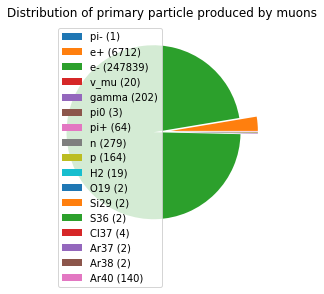

In [5]:
particle_dict = {11: "e-", -11: "e+", 22: "gamma", 2112: "n",
                211: "pi+", -211: "pi-", 111: "pi0", 14: "v_mu", 2212: "p", 
                1000180370: "Ar37", 1000180380: "Ar38", 1000180400: "Ar40", 
                1000010020: "H2", 1000080190: "O19", 1000140290: "Si29",
                1000160360: "S36", 1000170370: "Cl37"}

primary_interactions = df[df.ParentTrackID==1]
particle_dist = primary_interactions.groupby("PID").PID.count()
keys, values = particle_dist.keys(), particle_dist.values

labels = ["{} ({})".format(particle_dict[pid], values[i]) for i, pid in enumerate(keys)]
patches, texts = plt.pie(values, explode=[0.1]*len(keys))
plt.legend(patches, labels)
plt.title("Distribution of primary particle produced by muons")
plt.show()

### Energy deposition because of muon Ionization
Now, we try to profile the energy of the various induced interactions. In particular, we report the electrons forced by muon passage.

creatorprocess
muIoni                  240910
muMinusCaptureAtRest        25
muPairProd                6884
Name: creatorprocess, dtype: int64


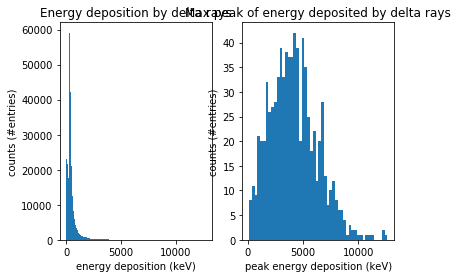

In [6]:
df = pd.read_csv(file_path, index_col=False)[fields]
plt.subplot(1, 2, 1)
electrons = df[(df.ParentTrackID==1) & (df.PID==11) & (df.energydeposition>0)]
print(electrons.groupby("creatorprocess").creatorprocess.count())

electrons = electrons[electrons.creatorprocess=="muIoni"]
plt.hist(electrons.energydeposition, 150)
plt.xlabel("energy deposition (keV)")
plt.ylabel("counts (#entries)")
plt.title("Energy deposition by delta rays")

plt.subplot(1, 2, 2)
max_peak = electrons.groupby("eventnumber").energydeposition.max()
plt.hist(max_peak.values, 50)
plt.xlabel("peak energy deposition (keV)")
plt.ylabel("counts (#entries)")
plt.title("Max peak of energy deposited by delta rays")
plt.show()


The deposited energy ranges in ~ [0, 12] MeV. However, for each simulated event, the electrons forced by muon ionization present a maximum peak in the order of a few MeV (*~4MeV on average*).

Concerning the spatial distribution of electrons, we notice that they present a very short lifetime, remaining confined around the muon trajectory. For example, in the next figure we plot the event `13` (**from old data**) in a 3d volume to illustrate this. The *blu* muon particles are completely covered by the *red* electrons.

[Info]	Load file ../Data/output123456789.csv
[Info]	Event 13 loaded.	Num entries: 880
[Info]	Found particles: [11, 13, 22]
	Plot particles: [11, 13, 22]


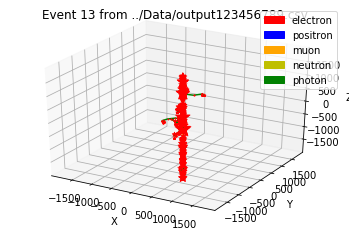

[Info] End.


In [7]:
%run -i ../Development/plot_event.py 13 --infile ../Data/output_Muon_123456789.csv

## Delayed-time of electrons and photons
Note we try to analyse the time spent by induced process. We are particularly interested in the time of energy depositions by electrons and primary photons.

**Note:** there are entries very far in time because of radioactive decays that occurs after years. We don't care about them because they will sum up to the background. Then we focus in energy deposition occurred in less than `10s` from the muon start.

In [8]:
# to clear the variables after having invoked another script in the same workspace
%reset -f
# import libraries and load data (only meaningful fields)
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 30})

fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output_Muon_10000.csv")
df = pd.read_csv(file_path, index_col=False)

[Info] CONSIDERING ENTRIES < 10 SEC, WE DISCARD 500/1792342 ENTRIES


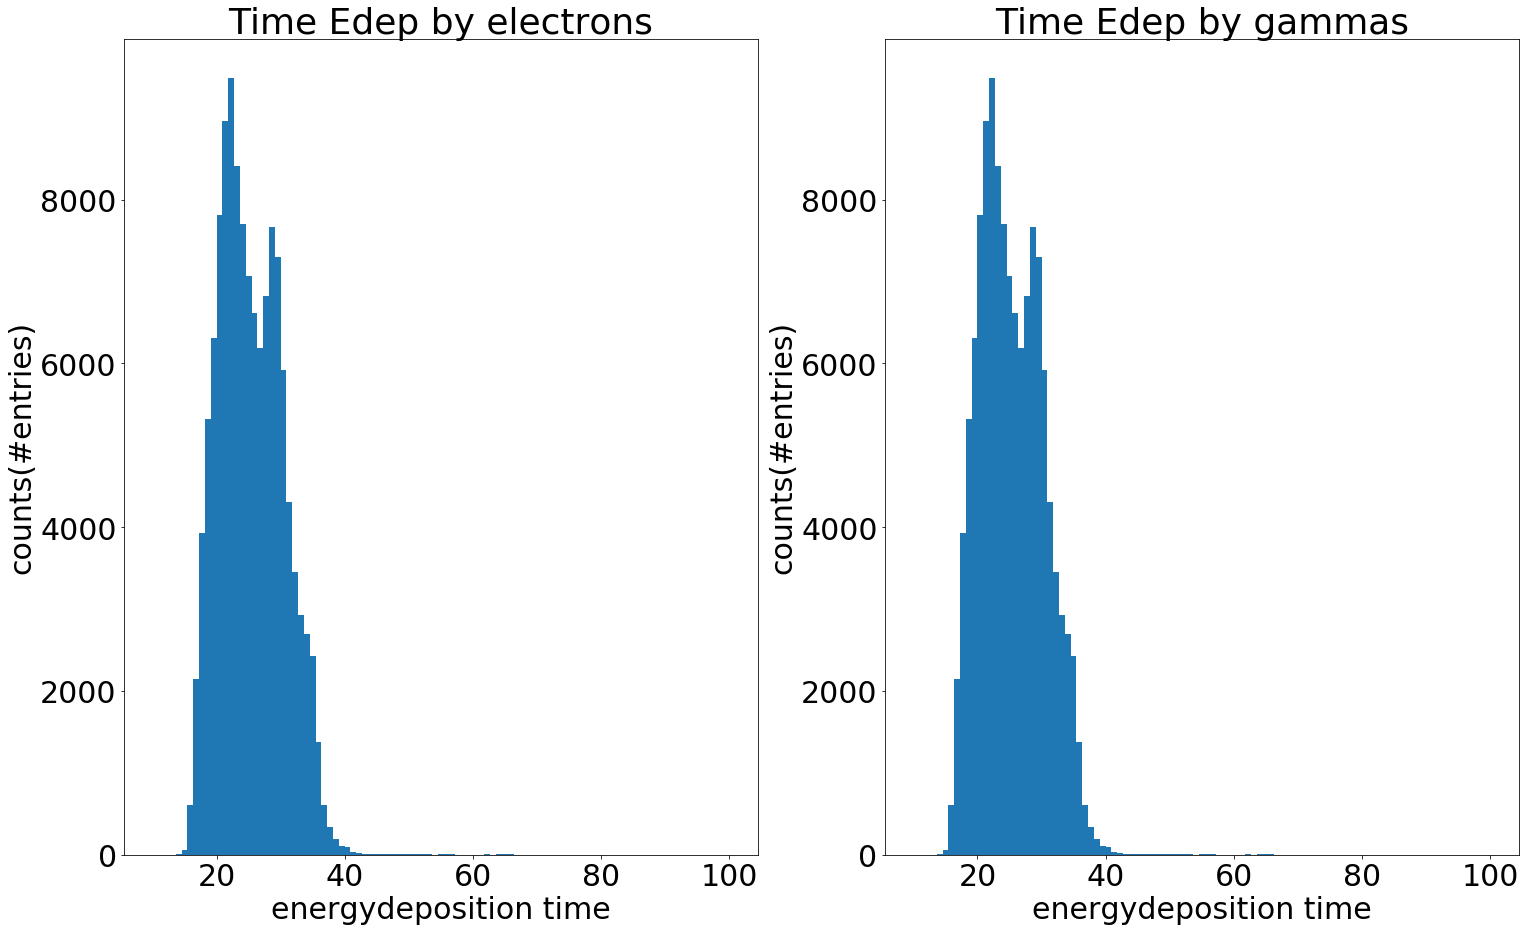

In [9]:
import numpy as np

MAX_TIME_WINDOW = 10**6    # .001 sec in ns
electrons = df[(df.PID==11) & (df.energydeposition>0) & (df.time<=MAX_TIME_WINDOW)].sort_values("time")
gammas = df[(df.PID==22) & (df.energydeposition>0) & (df.time<=MAX_TIME_WINDOW)].sort_values("time")

discarded = df[(df.PID.isin([11, 22])) & (df.energydeposition>0) & (df.time>MAX_TIME_WINDOW)].PID.count()
print("[Info] CONSIDERING ENTRIES < 10 SEC, WE DISCARD {}/{} ENTRIES".format(discarded, df.PID.count()))

bins = np.linspace(10, 100, 100)
plt.subplot(1, 2, 1)
plt.title("Time Edep by electrons")
plt.xlabel("energydeposition time")
plt.ylabel("counts(#entries)")
plt.hist(gammas.time, bins=bins)

plt.subplot(1, 2, 2)
plt.title("Time Edep by gammas")
plt.xlabel("energydeposition time")
plt.ylabel("counts(#entries)")
plt.hist(gammas.time, bins=bins)
plt.show()

We can note a very similar distribution of energy distribution by gamma and electrons. Most of the times in the order of `O(10ns)`, with minimum `~14ns` and maximum `~766000ns` = 0.76 ms.

**Note:** We are not scaling the time of energy deposition w.r.t. the muon deposition.

In [10]:
electrons.time.describe()

count    1.071982e+06
mean     1.595014e+02
std      7.123175e+03
min      1.399920e+01
25%      2.138400e+01
50%      2.481130e+01
75%      2.892180e+01
max      7.663210e+05
Name: time, dtype: float64

In [11]:
df[df.PID==13].sort_values("time").groupby("eventnumber").first().reset_index().time.describe()

count    806.000000
mean      20.668376
std        4.224437
min       13.996600
25%       17.192750
50%       19.761950
75%       22.952825
max       33.153000
Name: time, dtype: float64

# Analysis events in the ROI
In this section, we try to figure out the number of events that have caused an energy deposition in the surrouding of the ROI (*Ge+fiber shroud*).
In the LGND geometry, the ROI is delimited by the outer fiber array placed at radius `R=295 mm~300mm` from the origin and long `1500mm~1600mm`. Then, considering a margin of `200mm` on each side of the dimesions, we define the ROI as the area with x, y in `[-500,+500]` and z in `[-1000, +1000]`.

Secondly, we report some statistics about the number of events (i.e. muons) simulated, the number of events that present at least 1 entry in the related region, and the expected number of these events running 2G muons (*assuming linear scaling*).
Note that `884` events present 1 entry in LAr but only `806` present the muon passing in LAr. This means that in the other `78` events, the muon passes in the outer region but forces other process in LAr.

In [15]:
df_roi = df[(df.x>=-500) & (df.x<=+500) & (df.y>=-500) & (df.y<=+500) & (df.z>=-1000) & (df.z<=+1000)]
df_roi.eventnumber.nunique()

171

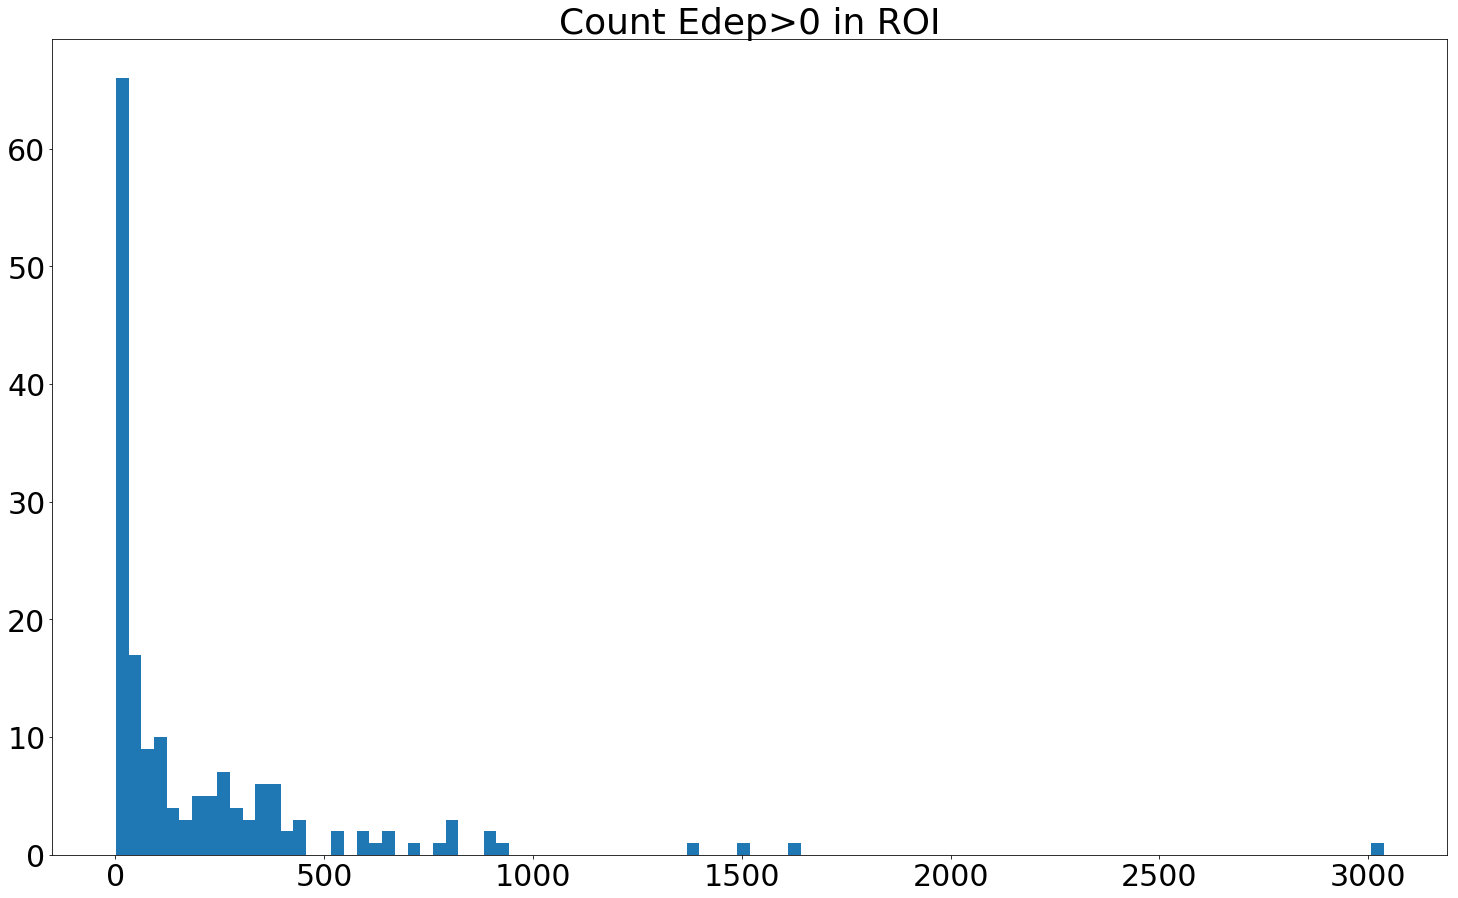

In [19]:
num_edep_x_event = df_roi[df_roi.energydeposition>0].groupby("eventnumber").PID.count().reset_index().PID
plt.hist(num_edep_x_event, 100)
plt.title("Count Edep>0 in ROI")
plt.show()

| Region    |   # events | effort    | E[# events \| 2M] |
|:----------|-----------:|----------:|------------------:|
| full geom | 10000      | 100.00 %  | 2000000           |
| LAr       | 884        |   8.84 %  |  176000           |
| ROI       | 171        |   1.71 %  |   34200           |


## First level: muon KE in LAr
Starting from musun distribution, we now see the KE, and angle distribution of muons that enter in LAr.

In [34]:
musun_columns = ["mu+-", "ke", "x", "y", "z", "theta", "phi"]
musun = pd.read_csv("../Data/musun/musun5000.dat", sep="\s+", names=musun_columns)

first_mu_lar = df[df.PID==13].sort_values("time").groupby("eventnumber").first().reset_index()
first_mu_lar

,eventnumber,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,tracknumber,creatorprocess,parentnucleusPID
0,2,13,0,69.5717,4.239560e+08,15.9907,1340.0400,446.4090,1949.6100,0.065483,0.307868,-0.949173,1,None,0
1,12,13,0,25112.8000,9.814000e+06,22.5175,1730.3700,705.9260,1200.9800,-0.634395,-0.042023,-0.771866,1,None,0
2,26,13,0,2138.6300,5.388090e+07,19.8843,-1644.5200,1044.4100,1128.6100,0.345272,0.260552,-0.901610,1,None,0
3,37,13,0,2445.1400,3.623400e+07,22.5916,-832.0040,-1759.1400,812.3760,-0.236750,0.489279,-0.839378,1,None,0
4,60,13,0,4725.3900,3.418020e+08,21.0712,469.4300,1127.4100,1932.3900,0.162168,0.671512,-0.723030,1,None,0
5,95,13,0,4243.5700,1.212470e+08,31.7152,-106.7170,725.1060,1940.7000,0.526087,0.707334,-0.472133,1,None,0
6,110,13,0,4818.3200,4.756050e+07,24.1358,-1464.9900,1264.9700,-925.9480,0.627356,-0.156892,-0.762764,1,None,0
7,111,13,0,1213.4700,1.624970e+08,17.7283,-1206.6500,904.4150,1944.4700,-0.036924,0.514047,-0.856967,1,None,0
8,139,13,0,6331.3500,3.376550e+07,20.0731,-1608.2100,1061.5200,-1482.7300,0.729558,-0.144656,-0.668445,1,None,0
9,148,13,0,6835.9000,2.480240e+08,25.3308,-1799.8600,-676.5130,-1154.0900,0.552849,0.531135,-0.642070,1,None,0
